# graph comparison

### generate and compare graphs from multiple networks within the Correlates of War dataset

The [Correlates of War](https://correlatesofwar.org/data-sets) website contains numerous data sets detailing various types of geo political relationships between countries for the last two centuries or so: geographic contiguity, trade, diplomatic relationships, armed conflict, etc. 

Each data set is in effect an edgelist for a type of relationship in place for a given period. Some are directed graphs (exports from country a to country b). Others are undirected (physical contiguity between countries).

For a [NECSI complex systems modelling class](https://necsi.edu/winter-school#week-2-cx202b), our team loaded selected networks into SQL for easy consolidation / slicing. From there we exported a single data file (cow_edgelist_v#), containing:

CoW INPUT:

- **node1, node2**: the country dyads
- **network**: the type of network mapping = directed or undirected
- **year**: 
 - CoW datafiles have all years represented
 - our analysis pulled four specific years: 1925, 1950, 1975, 2000
 - year = 1 means all historical records are consolidated into one edgelist
- **attribute**: the name of the weighting attribute corresponding to each network
- **value**: the attribute value for each dyad for the year. *can be used for weighting in future versions*

See CoW Data README in the repo for details on the data sources and each network we imported.

[Summary slides from our team project](https://docs.google.com/presentation/d/1XrEACjQyjzM-WBrBCBZB2Gt6x2YvJ5eeuoNuVJR7u7M/edit?usp=sharing).

## operation

**NOTE:** largest file I've run this on is <100K rows / edges. use at your own risk on big graph files

This script iterates through each network and year and generates metrics for each graph, saving them to results array and logging metric errors.

SETUP:

home directory contains:

- input data file: cow_edgelist_v3.csv
- fig folder for image
- file folder for csv outputs
- list of graph analysis functions to be run for each graph
- list of node level functions to run on each graph

FUNCTIONALITY:

- loads your edge list csv
- iterates through all networks
- creates a graph with 'value' as the edge attribute >> listed in variables
- runs through set of aggregate graph metrics >> listed in variables
- runs through digraph vs graph specific functions
- runs through set of centrality metrics
- saves aggregate csv file
- saves list of centrality metrics. NOTE: includes edgelist as dict in each row. XLS doesn't like this file!

TO RUN:

Run all in the notebook to process your data file.

To batch generate centrality sets against each other, see the batch generation section below and run the function.

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

import networkx as nx
import community as comm
# from networkx.algorithms import approximation


# read in data table
# edgelist

data = pd.read_csv('data/cow_edgelist_v3.csv', delimiter=',', 
            names = ['node1', 'node2', 'attribute', 'value', 'network', 'year'])


### network params to iterate through

In [28]:
# list of years to analyze
# year = 1 >> some graphs are aggregates of the whole period

# list year and networks you've got in the imported edgelist file

years = [1, 1925, 1950, 1975, 2000] 

networks = {'contiguity': 'undirected',
            'dip_exchange': 'undirected',
            'dir_alliances': 'undirected',
            'trade': 'directed',
            'terr_exchange': 'directed',
            'military_conflict': 'undirected'
           }

# weighting attribute per network
# not currently used
# attributes = ['contiguity_type','dip_rel_exists','alliance_types','exports_to','armed_conflict','highest_hostility']

# graph dictionary to build

g_dict = {}

# result set to build
# Networkx functions to run per graph. other functions should work if you import the appropriate library

# note: if you add an aggregate metric, also add it to the result_set list below, in the right order

metrics = [nx.number_of_nodes, nx.number_of_edges, nx.average_shortest_path_length,
              nx.average_clustering, nx.density, nx.diameter]

# also add new metrics to the header list (should have done this as a dictionary! oops. newbie)
result_set = [['network','net type','year','nodes','edges','avg_shortest_path_length','avg_clustering','density',
               'diameter', 'community']]

# add centrality measures or other functions that return a node list

cm = [nx.degree_centrality, nx.closeness_centrality, 
      nx.eigenvector_centrality, nx.in_degree_centrality, 
      nx.out_degree_centrality]

centrality_set = []

# error logging
errors = [['network','year','error']]



## function definitions - batches etc

these don't run automatically!

see batch processing examples below

In [29]:

def plot_cs(a,b):
    x = centrality_set[a]
    xnodes = x[5]
    y = centrality_set[b]
    ynodes = y[5]
    z = xnodes.keys() & ynodes.keys() # intersection of country codes
    xi=list((xnodes[k]) for k in z)
    yi=list((ynodes[k]) for k in z)

    # labels
    xn = str(x[0])
    yn = str(y[0])
    xy = str(x[1])
    yy = str(y[1])
    xf = str(x[2])
    yf = str(y[2])

    plot(xi,yi,'.')
    xlabel(xy + ' ' + xn + ' ' + xf + ' ')
    ylabel(yy + ' ' + yn + ' ' + yf + ' ')
    
    savefig("figures/"+xy+"-"+xn+"-"+xf+"-"+yy+"-"+yn+"-"+yf+'.png')


def get_row_years(gy):
    
    '''get rows from centrality sets for each year '''
    
    cs = pd.DataFrame(centrality_set)

    t = cs[cs.iloc[:][1] == gy] # subset the closeness set by year
    return t.index.values.tolist() # get the row numbers


def save_plots_by_year(sy):
    
    '''cycle through all permutations of centrality plots for each year '''
    
    rows = get_row_years(sy)
    
    for rowa in rows:
        for rowb in rows:
            cla()
            
            # doesn't run redundant plots. so not all centrality sets will generated on the x axis
            # saves (potentially hundreds of) files from being generated with each batch
            # use the single plot example below to plot a specific relationship
            if rowb > rowa:
                plot_cs(rowa, rowb)

    print("done")

    
def parse_f(fn):
    '''parses function name'''
    return str(fn).split(" ")[1]
    


## script: batch process all networks in the datafile

for all permutations of networks and years listed in 

any networkx errors thrown are logged to "errors". see bottom of page for error log

In [30]:


for n in networks.keys():

    for y in years:

        g_name = n+str(y)
        result = [n, networks[n], y]

        # slice edge list
        
        gslice = data[((data.network) == n) & ((data.year) == y)]
        
        if len(gslice) > 0:

            # create graph from sliced list
            # evaluate DiGraphs conditionally 
            
            if networks[n] == 'directed':
                G = nx.from_pandas_edgelist(gslice, 'node1', 'node2', ['value'], create_using=nx.DiGraph)
            else:
                G = nx.from_pandas_edgelist(gslice, 'node1', 'node2', ['value'], create_using=nx.Graph)

            # store graph    
                
            g_dict[g_name]=G
                
            # cycle through metrics and append to results
            for f in range(len(metrics)):
                
                fname = parse_f(metrics[f])
                
                try:
                    result.append(metrics[f](G))

            # capture and log which network, year, metric didn't calculate, return as -9
                except:
                    result.append(-9) 
                    errors.append([n,y,fname])

            # run functions specific to graph vs digraph
            if networks[n] == 'undirected':

                # community modularity
                try:
                # community modularity
                    bp = comm.best_partition(G)
                    mod = comm.modularity(bp,G)
                    result.append(mod)
               
                except:
                    result.append(-9)
                    errors.append([n,y,'comm.modularity failed'])

            else:
                result.append(-9)

            result_set.append(result)
            
            # loop through closeness metrics
            for l in range(len(cm)):
                
                fname = parse_f(cm[l])
                cresult = [n,y,fname]

                try:
                    x1 = cm[l](G)
                    
                    # build local result with # nodes results and result set
                    cresult.append(len(x1))
                    cresult.append(mean(list(x1.values()))) 
                    cresult.append(x1)
                    
                    #append to master result set
                    centrality_set.append(cresult)
                    
                    #save plot
                    
                except: 
                    cresult.append(-9) 
                    errors.append([n,y,fname]) 

## list of processed graphs

In [31]:
for key in g_dict.keys(): print(key)

contiguity1925
contiguity1950
contiguity1975
contiguity2000
dip_exchange1925
dip_exchange1950
dip_exchange1975
dip_exchange2000
dir_alliances1925
dir_alliances1950
dir_alliances1975
dir_alliances2000
trade1925
trade1950
trade1975
trade2000
terr_exchange1
military_conflict1


## show and list aggregate graph metrics

value = -9 means the function returned an error. usually just means the metric wasn't applicable to the graph

In [32]:
rs = pd.DataFrame(result_set)
rs.to_csv('files/result_set.csv')
rs


,0,1,2,3,4,5,6,7,8,9
0,network,net type,year,nodes,edges,avg_shortest_path_length,avg_clustering,density,diameter,community
1,contiguity,undirected,1925,55,142,-9,0.573821,0.0956229,-9,0.604915
2,contiguity,undirected,1950,70,161,-9,0.576298,0.0666667,-9,0.671675
3,contiguity,undirected,1975,146,413,5.17081,0.606736,0.0390175,13,0.737637
4,contiguity,undirected,2000,189,542,-9,0.566856,0.0305077,-9,0.745905
5,dip_exchange,undirected,1925,54,720,1.49755,0.798244,0.503145,3,0.128047
6,dip_exchange,undirected,1950,75,1070,1.63495,0.763217,0.385586,3,0.172236
7,dip_exchange,undirected,1975,143,4340,1.58682,0.756887,0.42746,3,0.119365
8,dip_exchange,undirected,2000,190,4406,1.78173,0.755048,0.245391,4,0.148837
9,dir_alliances,undirected,1925,26,41,-9,0.446886,0.126154,-9,0.610351


## save and list node centrality datasets

centrality node dictionary saved in col 5. 

as a result XLS really hates this file. open with text editor

In [38]:
cs = pd.DataFrame(centrality_set)
cs.to_csv('files/centrality_set.csv')
cs


,0,1,2,3,4,5
0,contiguity,1925,degree_centrality,55,0.095623,"{345: 0.12962962962962962, 305: 0.111111111111..."
1,contiguity,1925,closeness_centrality,55,0.209865,"{345: 0.2619047619047619, 305: 0.2725225225225..."
2,contiguity,1925,eigenvector_centrality,55,0.082450,"{345: 0.04843714682303827, 305: 0.093149574203..."
3,contiguity,1950,degree_centrality,70,0.066667,"{41: 0.043478260869565216, 40: 0.0724637681159..."
4,contiguity,1950,closeness_centrality,70,0.192336,"{41: 0.13598519888991675, 40: 0.12290969899665..."
...,...,...,...,...,...,...
59,terr_exchange,1,in_degree_centrality,177,0.007094,"{483: 0.005681818181818182, 620: 0.00568181818..."
60,terr_exchange,1,out_degree_centrality,177,0.007094,"{483: 0.005681818181818182, 620: 0.0, 581: 0.0..."
61,military_conflict,1,degree_centrality,174,0.047771,"{58: 0.011560693641618497, 40: 0.1156069364161..."
62,military_conflict,1,closeness_centrality,174,0.366269,"{58: 0.3094812164579606, 40: 0.444730077120822..."


# doing things with the processed graphs

the individual graphs, aggregate graph metric table and centrality data are now available for you to play with here

### find a graph to draw

In [34]:
search_term = "1925" # use network or year  

for key in g_dict.keys():
    if key.find(search_term) != -1:
        print(key)

contiguity1925
dip_exchange1925
dir_alliances1925
trade1925


### example: nx.draw a basic graph

grab a graph name from the graph list above, add to the draw function below

be patient it takes a second

In [35]:
# uncomment one of these to turn inline vs external image plotting
%matplotlib inline
# %matplotlib auto

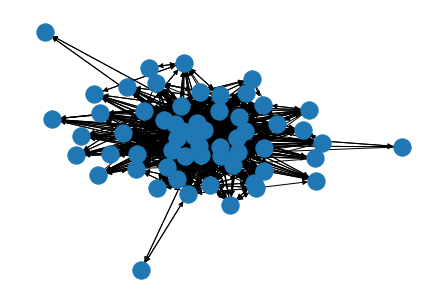

In [39]:
draw_this = 'trade1925'
nx.draw(g_dict[draw_this]);

### example: generate a single specific plot of two centrality sets

call two centrality sets from list above to generate a plot

plots intersection of the countries since they might not all be present in both sets

saves the plot to figs/ folder

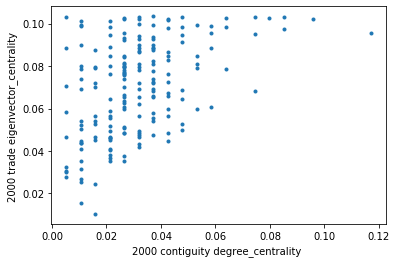

In [37]:
plot_cs(9,53);

# example: link between physical contiguity and trade
# importance of geography to trade relationships

### batch generate centrality plots for a given year

execute this function to generate all plot permutations

```save_plots_by_year(2000)```

this plots the intersection of the countries between the two centrality sets. not all countries are present in all graphs

**NOTE:** this can generate HUNDREDS of graphs

**NOTE:** generates redundant graphs for x and y: (x,y) and (y,x)


### your turn...

### error log from file processing

any errors generated in graph processing are logged to "errors". for a list:

```print(errors)```
